# Debugging Practicum I
In this class, we'll use all the tools at our disposal to fix some code that isn't working. [The data](https://drive.google.com/file/d/1t2JIa8WYFjHqm4Eg_pjSQQTZ44uH68ni/view?usp=sharing) for this exercise are time series of pupil measurements taken while a participant completed an ["oddball" task](https://en.wikipedia.org/wiki/Oddball_paradigm), and the analysis performed is plotting trial-averaged pupil responses to standard and deviant sounds, locked to stimulus presentation. As with most code in the wild, this is only lightly commented. This constitutes what is often called a [minimal working example](https://en.wikipedia.org/wiki/Minimal_Working_Example) (MWE), apart from the fact that it's not quite minimal and not quite working.

The complete code, put together as a Jupyter notebook, is available [here](https://colab.research.google.com/drive/1n8rwZZOX7gaHQ33XlH5EEVR5E6VAfVkP?usp=sharing), but is also listed below. Your goal in class, using whatever means you have at your disposal, is to find and remove the bugs. The expected output figure from the code is also given below.

````{admonition} Exercise
Fix the code. Note that not all bugs generate errors. To find some bugs, you will need to understand what the pieces of the code are trying to accomplish. Using the debugger to help you trace the code may be very helpful.

As usual, you can download directly using
```
!gdown 1t2JIa8WYFjHqm4Eg_pjSQQTZ44uH68ni
```
````



## Code listing:

In [1]:
# download the data
!gdown 1t2JIa8WYFjHqm4Eg_pjSQQTZ44uH68ni

Downloading...
From: https://drive.google.com/uc?id=1t2JIa8WYFjHqm4Eg_pjSQQTZ44uH68ni
To: /Users/jmxp/code/neural-data-analysis-book/introduction_to_neural_data_analysis/debugging/pupil.mat
100%|████████████████████████████████████████| 104k/104k [00:00<00:00, 74.3MB/s]


In [3]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
import seaborn as sns

In [9]:
dat = loadmat('data/pupil.mat', struct_as_record=False)

# make a dataframe
eye_df = pd.DataFrame({'pupil': dat['pupil'], 
                      }, index=dat['taxis'].squeeze())

evt_times = dat['evttimes'].squeeze()
was_odd = dat['trialvec'].squeeze() == 1

sr = 60  # sampling rate (samples/sec)
t_pre = -0.3  # time before event to grab (sec)
t_post = 0.8  # time after event to grab (sec)
norm_type = 'subtract'  # 'subtract' or 'divide'

series = eye_df.pupil.values

FileNotFoundError: [Errno 2] No such file or directory: 'data/pupil.mat'

In [10]:
def evtsplit(series, events, t_start, t_end, sr=1, t0=0):
    # splits a time series around given events
    # series: time series to split
    # events: times around which to split
    # t_start: time before event to grab (< 0 for times before)
    # t_end: time after event to grab
    # sr: sampling rate
    # t0: time at which to begin splitting
    #
    # returns: 
    # outdat: split time series, one row per event
    # time: time axis relative to event
    
    num_evt = len(events)  # number of event timestamps
    dt = 1/sr  # time bin size
    nstart = int(np.ceil(t_start * sr))  # number of bins to grab before
    nend = int(np.ceil(t_end * sr))  # number of bins to grab after

    evt_rel = events - t0  # relative event time

    # preallocate output matrix
    outdat = np.empty((num_evt, np.abs(nstart) + np.abs(nend) + 1))  # npre + npost + (0 bin)
    outdat[:] = np.nan

    for ind in range(num_evt):
        bins_to_grab = np.arange(nstart, nend + 1) + int(np.around(evt_rel[ind]/dt));

        # now take care of ends of time series
        if bins_to_grab[0] < 1:   # if we're at the start of series...
            bins_to_grab = bins_to_grab[bins_to_grab >= 1]  # truncate
            outdat[ind, -len(bins_to_grab):] = series[bins_to_grab]
        elif bins_to_grab[-1] > len(series):
            bins_to_grab = bins_to_grab[bins_to_grab < len(series)]
            outdat[ind, :len(bins_to_grab)] = series[bins_to_grab]
        else:
            outdat[ind] = series[bins_to_grab]
    
    return outdat, np.arange(nstart, nend) * dt


def baseline_normalize(series, t_axis, norm_interval, method='subtract'):
    # given a numpy array, series, each row of which is a time series
    # and a time axis t_axis
    # and an interval of times [norm_interval[0], norm_interval[1]) 
    # over which to normalize, normalize according to a baseline calculated in that interval
    # method: 
    #    'subtract': subtract baseline
    #    'divide': divide by baseline
    
    bool_interval = (t_axis >= norm_interval[0]) & (t_axis < norm_interval[1])
    outdata = np.full_like(series, np.nan)
    
    for row in range(outdata.shape[0]):
        if method == 'subtract':
            outdata[row] = series[row] - np.mean(series[row, bool_interval])
        elif method == 'divide':
            outdata[row] = series[row] / np.mean(series[row, bool_interval])
        else:
            raise ValueError("method must be one of {'subtract', 'divide}'")
            
    return outdata

In [11]:
splits, t_axis = evtsplit(series, evt_times, t_pre, t_post, sr=sr)
t_interval = [-np.inf, 0]

pupil_correct = baseline_normalize(splits[was_odd], t_axis, t_interval, method=norm_type)
pupil_incorrect = baseline_normalize(splits[~was_odd], t_axis, t_interval, method=norm_type)

corr_mean = np.nanmean(pupil_correct, 0)
inc_mean = np.nanmean(pupil_incorrect, 0)

corr_sem = np.nanstd(pupil_correct, 0)/np.sqrt(pupil_correct.shape[0])
inc_sem = np.nanstd(pupil_incorrect, 0)/np.sqrt(pupil_incorrect.shape[0])

sns.set_context('poster')
plt.figure(figsize=(10, 6))
plt.fill_between(t_axis, corr_mean + corr_sem, corr_mean + corr_sem, alpha=0.5)
plt.fill_between(t_axis, inc_mean - inc_sem, inc_mean + inc_sem, alpha=0.5)
plt.plot(t_axis, corr_mean)
plt.plot(t_axis, inc_mean)
plt.title('Pupillary response to oddball')
plt.xlabel('Time from sound (seconds)')
plt.ylabel('Normalized pupil size (a.u.)')
plt.legend(['Oddball', 'Standard']);

IndexError: boolean index did not match indexed array along dimension 1; dimension is 499 but corresponding boolean dimension is 498

## Solution:

```{toggle}
1. In the second cell, `dat['pupil']` needs to be `squeeze`d before constructing the DataFrame.
1. In the same cell, the post-event time is wrong. It should be 8 to match the figure.
1. In `evtsplit`, last line: The returned time axis should be a shifted `np.arange(nstart, nend + 1)`.
1. In `baseline_normalize`, the `mean` should exclude `nan` (i.e., `nanmean`).
1. In the plotting code, first `fill_between`, the first `+` should be `-`.
```

In [4]:
dat = loadmat('pupil.mat', struct_as_record=False)

# make a dataframe
eye_df = pd.DataFrame({'pupil': dat['pupil'].squeeze(), 
                      }, index=dat['taxis'].squeeze())

evt_times = dat['evttimes'].squeeze()
was_odd = dat['trialvec'].squeeze() == 1

sr = 60  # sampling rate (samples/sec)
t_pre = -0.3  # time before event to grab (sec)
t_post = 8  # time after event to grab (sec)
norm_type = 'subtract'  # 'subtract' or 'divide'

series = eye_df.pupil.values



In [5]:
def evtsplit(series, events, t_start, t_end, sr=1, t0=0):
    # splits a time series around given events
    # series: time series to split
    # events: times around which to split
    # t_start: time before event to grab (< 0 for times before)
    # t_end: time after event to grab
    # sr: sampling rate
    # t0: time at which to begin splitting
    #
    # returns: 
    # outdat: split time series, one row per event
    # time: time axis relative to event
    
    num_evt = len(events)  # number of event timestamps
    dt = 1/sr  # time bin size
    nstart = int(np.ceil(t_start * sr))  # number of bins to grab before
    nend = int(np.ceil(t_end * sr))  # number of bins to grab after

    evt_rel = events - t0  # relative event time

    # preallocate output matrix
    outdat = np.empty((num_evt, np.abs(nstart) + np.abs(nend) + 1))  # npre + npost + (0 bin)
    outdat[:] = np.nan

    for ind in range(num_evt):
        bins_to_grab = np.arange(nstart, nend + 1) + int(np.around(evt_rel[ind]/dt));

        # now take care of ends of time series
        if bins_to_grab[0] < 1:   # if we're at the start of series...
            bins_to_grab = bins_to_grab[bins_to_grab >= 1]  # truncate
            outdat[ind, -len(bins_to_grab):] = series[bins_to_grab]
        elif bins_to_grab[-1] > len(series):
            bins_to_grab = bins_to_grab[bins_to_grab < len(series)]
            outdat[ind, :len(bins_to_grab)] = series[bins_to_grab]
        else:
            outdat[ind] = series[bins_to_grab]
    
    return outdat, np.arange(nstart, nend + 1) * dt


def baseline_normalize(series, t_axis, norm_interval, method='subtract'):
    # given a numpy array, series, each row of which is a time series
    # and a time axis t_axis
    # and an interval of times [norm_interval[0], norm_interval[1]) 
    # over which to normalize, normalize according to a baseline calculated in that interval
    # method: 
    #    'subtract': subtract baseline
    #    'divide': divide by baseline
    
    bool_interval = (t_axis >= norm_interval[0]) & (t_axis < norm_interval[1])
    outdata = np.full_like(series, np.nan)
    
    for row in range(outdata.shape[0]):
        if method == 'subtract':
            outdata[row] = series[row] - np.nanmean(series[row, bool_interval])
        elif method == 'divide':
            outdata[row] = series[row] / np.nanmean(series[row, bool_interval])
        else:
            raise ValueError("method must be one of {'subtract', 'divide}'")
            
    return outdata

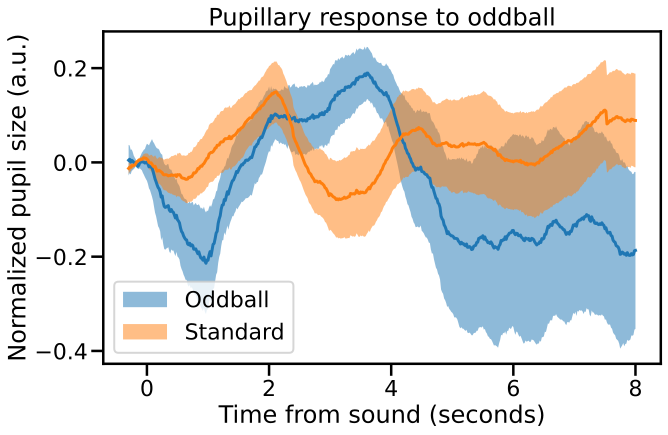

In [8]:
splits, t_axis = evtsplit(series, evt_times, t_pre, t_post, sr=sr)
t_interval = [-np.inf, 0]

pupil_correct = baseline_normalize(splits[was_odd], t_axis, t_interval, method=norm_type)
pupil_incorrect = baseline_normalize(splits[~was_odd], t_axis, t_interval, method=norm_type)

corr_mean = np.nanmean(pupil_correct, 0)
inc_mean = np.nanmean(pupil_incorrect, 0)

corr_sem = np.nanstd(pupil_correct, 0)/np.sqrt(pupil_correct.shape[0])
inc_sem = np.nanstd(pupil_incorrect, 0)/np.sqrt(pupil_incorrect.shape[0])

sns.set_context('poster')
plt.figure(figsize=(10, 6))
plt.fill_between(t_axis, corr_mean - corr_sem, corr_mean + corr_sem, alpha=0.5)
plt.fill_between(t_axis, inc_mean - inc_sem, inc_mean + inc_sem, alpha=0.5)
plt.plot(t_axis, corr_mean)
plt.plot(t_axis, inc_mean)
plt.title('Pupillary response to oddball')
plt.xlabel('Time from sound (seconds)')
plt.ylabel('Normalized pupil size (a.u.)')
plt.legend(['Oddball', 'Standard']);